In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#export
import json
import sys
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from basedir import NUM_CLASSES

In [ ]:
#export
import contextlib, io
with contextlib.redirect_stderr(io.StringIO()):
    from data_bunch import DataBunch, RxRxDataset, load_data, rio

## Plots

In [ ]:
# Plots visual style setup

class VisualStyle:
    """Convenience wrapper on top of matplotlib config."""

    def __init__(self, config, default=None):
        if default is None:
            default = plt.rcParams
        self.default = default.copy()
        self.config = config

    def replace(self):
        plt.rcParams = self.config

    def override(self, extra=None):
        plt.rcParams.update(self.config)
        if extra is not None:
            plt.rcParams.update(extra)

    def restore(self):
        plt.rcParams = self.default

    def __enter__(self):
        self.override()
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.restore()

        
palette1 = '173f5f 20639b 3caea3 f6d55c ed553b'
palette2 = '264653 2a9d8f e9c46a f4a261 e76f51'
tableau = '4e79a7 f28e2b e15759 76b7b2 59a14f edc948 b07aa1 ff9da7 9c755f bab0ac'

def make_cycler(colors):
    from cycler import cycler
    colors_str = ', '.join([f"'{c}'" for c in colors.split()])
    return f"cycler('color', [{colors_str}])"
    
class NotebookStyle(VisualStyle):
    def __init__(self):
        super().__init__({
            'figure.figsize': (10, 8),
            'font.family': 'monospace',
            'axes.titlesize': 18,
            'axes.labelsize': 16,
            'axes.spines.right': False,
            'axes.spines.top': False,
            'xtick.labelsize': 14,
            'ytick.labelsize': 14,
            'font.size': 14,
            'axes.prop_cycle': make_cycler(tableau)
        })
        
def show_all(df):
    with pd.option_context('display.max_columns', None, 'display.max_rows', None):
        display(df)
        
NotebookStyle().override()
sns.set_palette([f'#{color}' for color in tableau.split()])

In [ ]:
def build_referece(records):
    from copy import deepcopy
    records = deepcopy(records)
    images_index = {}
    for r in records:
        rec_id = '{}_{}_{}'.format(r['experiment'], r['plate'], r['site'])
        images_index[rec_id] = r.pop('images')
        r['rec_id'] = rec_id
    return pd.DataFrame(records).set_index('rec_id'), images_index

In [ ]:
def rgb(record):
    filenames = [path for _, path in record['images']]
    t = rio.load_images_as_tensor(filenames)
    img = rio.convert_tensor_to_rgb(t)
    return img

In [ ]:
def show(record):
    plt.imshow(rgb(record))

In [ ]:
trn_rec, tst_rec = load_data()

In [ ]:
trn_idx, trn_img = build_referece(trn_rec)

In [ ]:
trn_idx.sample(3)

In [ ]:
trn_idx.experiment.value_counts().plot.bar();

In [ ]:
trn_idx.plate.value_counts().plot.barh();

In [ ]:
trn_idx.cell_type.value_counts(normalize=True).plot.barh();

## Cell Type Classifier

In [4]:
#export
import torch
import torch.nn as nn 
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader
import torchvision.transforms as T
import pretrainedmodels
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm_notebook as tqdm

from catalyst.dl import SupervisedRunner
from catalyst.contrib.schedulers import OneCycleLR
from catalyst.contrib.modules import GlobalConcatPool2d
from catalyst.dl.callbacks import AccuracyCallback, AUCCallback

In [ ]:
#export
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [ ]:
#export
def encode(train, test):
    enc = LabelEncoder()
    train_labels = [x['cell_type'] for x in train]
    enc.fit(train_labels)
    enc_train_labels = enc.transform(train_labels)
    for train_record, train_label in zip(train, enc_train_labels):
        train_record['cell_type_enc'] = train_label
    for test_record in test:
        test_record['cell_type_enc'] = 0
    return enc

In [ ]:
#export
from catalyst.dl.core import Callback
from visdom import Visdom
from pdb import set_trace


class VisdomCallback(Callback):
    
    def __init__(self, 
                 username='username', password='password', 
                 host='0.0.0.0', port=9090, use_env_creds=False):
        """
        Args:
            username (str): Visdom server username.
            password (str): Visdom server password.
            host (str): Visdom server address.
            port (int): Visdom server port.
            use_env_creds (bool): If True, then ignore credentials
                passed as __init__ parameters and use Visdom 
                environment variables instead.
        """
        
        super().__init__()

        if use_env_creds:
            username = os.environ['VISDOM_USERNAME']
            password = os.environ['VISDOM_PASSWORD']
            
        self.vis = Visdom(
            username=username, password=password,
            server=host, port=port)        

        
class BatchMetricsPlotCallback(VisdomCallback):

    def on_batch_end(self, state):
        for k, v in state.metrics.batch_values.items():
            self.vis.line(X=[state.step], Y=[v], win=k, name=k, 
                          update='append', opts=dict(title=k))
            
            
class EpochMetricsPlotCallback(VisdomCallback):
    
    def on_epoch_end(self, state):
        for k, v in state.metrics.batch_values.items():
            self.vis.line(X=[state.step], Y=[v], win=k, name=k,
                          update='append', opts=dict(title=k))

In [ ]:
#export
batch_size = 600
bunch = DataBunch(
    targets_key='cell_type_enc', 
    stats={'mean': (0.5,), 'std': (0.5,)},
    channels_mode='six')
trn_rec, tst_rec = load_data()
encoder = encode(trn_rec, tst_rec)
datasets = bunch.create(trn_rec, tst_rec, batch_size=batch_size)
test_dl = datasets.pop('test')

In [5]:
#export
def build_model():
    model = pretrainedmodels.resnet50()
    model.avgpool = GlobalConcatPool2d()
    model.last_linear = nn.Sequential(
        nn.Linear(4096, 2048),
        nn.Dropout(0.5),
        nn.ReLU(inplace=True),
        nn.Linear(2048, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(1024, 4)
    )
    conv1 = model.conv1
    new_conv = nn.Conv2d(6, 64, 7, 2, 3, bias=False)
    new_conv.weight.data[:,0:3,:] = conv1.weight.data.clone()
    new_conv.weight.data[:,3:6,:] = conv1.weight.data.clone()
    model.conv1 = new_conv
    del conv1
    return model
    
def freeze_all(model):
    for param in model.parameters():
        param.requires_grad = False
        
def unfreeze_head(model):
    for param in model.last_linear.parameters():
        param.requires_grad = True

In [ ]:
#export
epochs = 3
model = build_model()
freeze_all(model)
unfreeze_head(model)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.1)
sched = CosineAnnealingWarmRestarts(opt, T_0=len(datasets['train']), T_mult=2, eta_min=1e-6)
loss_fn = nn.CrossEntropyLoss()
runner = SupervisedRunner()

In [ ]:
#export
runner.train(
    model=model,
    num_epochs=epochs,
    criterion=loss_fn,
    optimizer=opt,
    scheduler=sched,
    logdir='/tmp/cell_type/',
    loaders=datasets,
    callbacks=[
        AccuracyCallback(num_classes=4),
        BatchMetricsPlotCallback(use_env_creds=True),
        EpochMetricsPlotCallback(use_env_creds=True)
    ],
    verbose=True
)

In [ ]:
!python -m jupytools export -nb "00c_visualization.ipynb" -o . 

## Predict Features

In [6]:
best_checkpoint = torch.load('/tmp/cell_type/checkpoints/best.pth')

In [ ]:
# map_location=lambda storage, loc: storage

In [7]:
model = build_model()
freeze_all(model)
model.load_state_dict(best_checkpoint['model_state_dict'])
model.last_linear = nn.Sequential(*model.last_linear[:-3])
model = model.to('cuda:1')

In [18]:
trn_rec, tst_rec = load_data()
rec = trn_rec + tst_rec
enc = LabelEncoder()
y = enc.fit_transform([r['cell_type'] for r in rec])
for r, target in zip(rec, y):
    r['cell_type_enc'] = target
ds = RxRxDataset(
    items=rec,
    onehot=False, 
    drop_meta=False,
    channels_mode='six',
    tr=T.Compose([
        T.Resize(224),
        T.ToTensor(),
        T.Normalize((0.5,), (0.5,))
    ])
)
dl = DataLoader(ds, shuffle=True, batch_size=500, num_workers=12)

In [19]:
for b in dl:
    out = model(b['features'].to('cuda:1'))
    break

In [20]:
out.shape

torch.Size([500, 1024])

In [33]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [23]:
arr = out.detach().cpu().numpy()

In [32]:
cluster = KMeans(n_clusters=4, n_jobs=12)
cluster.fit(arr)
clusters = cluster.predict(arr)

In [34]:
pca = PCA(n_components=2).fit(arr)

In [38]:
pca_data = pca.transform(arr)

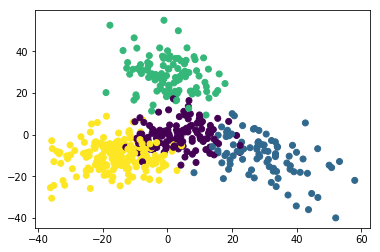

In [41]:
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters)

In [42]:
!pip install bokeh

In [43]:
from math import sin
from random import random

from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper
from bokeh.palettes import plasma
from bokeh.plotting import figure
from bokeh.transform import transform

list_x = list(range(100))
list_y = [random() + sin(i / 20) for i in range(100)]
desc = [str(i) for i in list_y]

source = ColumnDataSource(data=dict(x=list_x, y=list_y, desc=desc))
hover = HoverTool(tooltips=[
    ("index", "$index"),
    ("(x,y)", "(@x, @y)"),
    ('desc', '@desc'),
])
mapper = LinearColorMapper(palette=plasma(256), low=min(list_y), high=max(list_y))

p = figure(plot_width=400, plot_height=400, tools=[hover], title="Belgian test")
p.circle('x', 'y', size=10, source=source,
         fill_color=transform('y', mapper))

output_file('test.html')
show(p)

## Debug

In [ ]:
# def accuracy(y_pred, y_true):
#     if len(y_pred.shape) == 1:
#         return (y_pred == y_true).float().mean()
#     elif len(y_pred.shape) == 2:
#         y_pred = y_pred.argmax(dim=1).softmax(dim=1)
#         return accuracy(y_pred, y_true)
#     raise ValueError(f'unexpected y_pred shape: {y_pred.shape}')

In [ ]:
# DEVICE = torch.device('cuda:1')

In [ ]:
# epochs = 3
# model = build_model()
# freeze_all(model)
# unfreeze_head(model)
# opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.1)
# sched = CosineAnnealingWarmRestarts(opt, T_0=len(datasets['train']), T_mult=2, eta_min=1e-6)
# loss_fn = nn.CrossEntropyLoss()

In [ ]:
# model = model.to(DEVICE)
# for epoch in range(1, epochs+1):
#     trn_dl = datasets['train']
#     n = len(trn_dl)
#     with tqdm(total=n) as bar:
#         for i, batch in enumerate(trn_dl):
#             opt.zero_grad()
#             x, y = [t.to(DEVICE) for t in (batch['features'], batch['targets'])]
#             out = model(x)
#             loss = loss_fn(out, y)
#             loss.backward()
#             acc = accuracy(out, y)
#             bar.set_prefix(title=f'[epoch:{epoch}/{epochs+1}][batch:{i}/{n}]')
#             bar.set_postfix(f'acc:{acc:2.2%}')
#             opt.step()
#             sched.step()
#             bar.update(1)
#             break
#     break